In [18]:
%matplotlib inline
import seaborn as sns; 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import gridspec
import scipy
import time
import numpy as np
style.use('ggplot')
sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
plt.rcParams['text.usetex'] = True

PALETTE_BASE = sns.color_palette('muted', n_colors=12)
blue=PALETTE_BASE[0]
green=PALETTE_BASE[1] 
red=PALETTE_BASE[2] 
purple=PALETTE_BASE[3]
flatui = [sns.xkcd_rgb["medium green"], "orange", sns.xkcd_rgb["medium purple"], "#e74c3c", "#34495e", "#2ecc71"]
colors = {'official': 'green',
         'community': blue,
         'Oldstable': PALETTE_BASE[-4],
          'Stable': PALETTE_BASE[-5],
          'Testing': PALETTE_BASE[-6],
          'Higher': 'red',
          'Medium': flatui[1],
          'Lower': flatui[0]
         }
# Considered period for the analysis
first_date="2016-07-01"
last_date="2019-06-01"
date_period = pd.to_datetime(first_date), pd.to_datetime(last_date)
release_map={'jessie':'Oldstable',
             'stretch':'Stable',
             'buster':'Testing'}
type_map={'o':'official',
          'c':'community'}

# Load image lag

In [57]:
all_lags = pd.read_csv('../../../docker_emse/csv/for_analysis/image_lags.csv', dtype=object)
all_lags.shape

(140496, 10)

In [58]:
all_lags.head(2)

,image,release,type,last_updated,cve_lag,bug_lag,vlag,tlag,outdated,packages
0,010309:mmmiddleware:0.9.25,Stable,community,2017-11-01,0.0,0.0,0.0,0.0,0.0,82
1,010309:mmmiddleware:0.9.26,Stable,community,2017-11-12,0.0,0.0,0.0,0.0,0.0,82


In [59]:
all_lags.rename(columns={'cve_lag':'vuln',
                         'bug_lag':'bug',
                         'vlag':'version',
                         'tlag':'time',
                         'outdated':'pkg'}, inplace=True)

In [60]:
for x in ['vuln','bug','time','version','pkg','packages']:
    all_lags[x] = all_lags[x].apply(float)

In [61]:
(all_lags
 .query('type=="official"')
 [['vuln','bug','time','version','pkg']]
 .corr(method="spearman")
 .style
 .format("{:.2}")
 .background_gradient(cmap=plt.get_cmap('Greys'), axis=1)
)

,vuln,bug,time,version,pkg
vuln,1.0,-0.0025,0.87,0.86,0.86
bug,-0.0025,1.0,0.084,0.09,0.09
time,0.87,0.084,1.0,0.95,0.95
version,0.86,0.09,0.95,1.0,1.0
pkg,0.86,0.09,0.95,1.0,1.0


In [62]:
tot=(all_lags
 .query('type=="official"')
 [['vuln','bug','time','version','pkg']]
 .corr(method="pearson")
 .style
 .format("{:.2}")
 .background_gradient(cmap=plt.get_cmap('Greys'), axis=1)
)

In [8]:
corr = (all_lags
 [['vuln','bug','time','version','pkg']]
 .corr(method="pearson"))

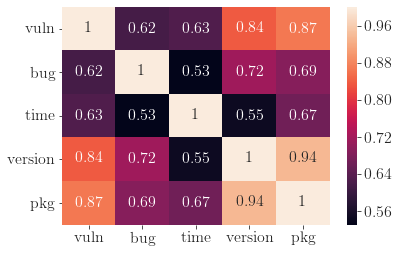

In [11]:
corr = (all_lags
 [['vuln','bug','time','version','pkg']]
 .corr(method="pearson"))
ax=sns.heatmap(corr, annot = True)
#ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/corr-pearson.pdf', bbox_inches='tight', facecolor='white')

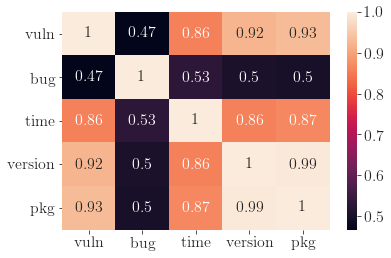

In [12]:
corr = (all_lags
 [['vuln','bug','time','version','pkg']]
 .corr(method="spearman"))
ax=sns.heatmap(corr, annot = True)
#ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/corr-spearman.pdf', bbox_inches='tight', facecolor='white')

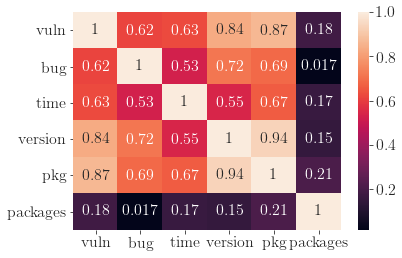

In [271]:
corr = (all_lags
 [['vuln','bug','time','version','pkg','packages']]
 .corr(method="pearson"))
ax=sns.heatmap(corr, annot = True)
#ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/corr-spearman.pdf', bbox_inches='tight', facecolor='white')

In [258]:
for i, col1 in enumerate(['vuln','bug','time','version','pkg']):
    for j, col2 in enumerate(['vuln','bug','time','version','pkg','packages']):
        if j>i:
            print(col1, col2, scipy.stats.spearmanr(all_lags[col1], all_lags[col2]))


vuln bug SpearmanrResult(correlation=0.46665445177969817, pvalue=0.0)
vuln time SpearmanrResult(correlation=0.8588454033015509, pvalue=0.0)
vuln version SpearmanrResult(correlation=0.924721648013599, pvalue=0.0)
vuln pkg SpearmanrResult(correlation=0.9316789981827731, pvalue=0.0)


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


vuln packages SpearmanrResult(correlation=0.16720834913991428, pvalue=0.0)
bug time SpearmanrResult(correlation=0.5295481066940922, pvalue=0.0)
bug version SpearmanrResult(correlation=0.5045798821325009, pvalue=0.0)
bug pkg SpearmanrResult(correlation=0.5014446901665072, pvalue=0.0)
bug packages SpearmanrResult(correlation=0.00037278752792678467, pvalue=0.888873361500539)
time version SpearmanrResult(correlation=0.8587977966419391, pvalue=0.0)
time pkg SpearmanrResult(correlation=0.867650285042924, pvalue=0.0)
time packages SpearmanrResult(correlation=0.12731428484919918, pvalue=0.0)
version pkg SpearmanrResult(correlation=0.9949093458378263, pvalue=0.0)
version packages SpearmanrResult(correlation=0.1467376028825794, pvalue=0.0)
pkg packages SpearmanrResult(correlation=0.15880479420855453, pvalue=0.0)


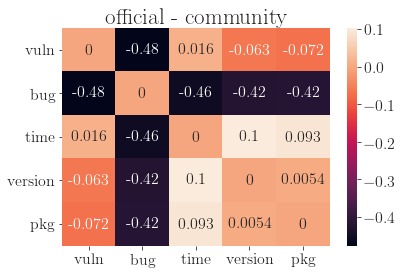

In [268]:
corr = (all_lags
        .query('type=="official"')
        [['vuln','bug','time','version','pkg']]
        .corr(method="spearman"))

corr2 = (all_lags
        .query('type=="community"')
        [['vuln','bug','time','version','pkg']]
        .corr(method="spearman"))

ax=sns.heatmap(corr - corr2, annot = True)
ax.set_title('official - community')
ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/corr-difference.pdf', bbox_inches='tight', facecolor='white')

,image,variable,value
0,010309:mmmiddleware:0.9.25,time,0.0
1,010309:mmmiddleware:0.9.26,time,0.0
2,010309:mmmiddleware:0.9.28,time,0.0
3,010309:mmmiddleware:0.9.29,time,0.0
4,010309:mmmiddleware:0.9.30,time,0.0
...,...,...,...
702475,zzorba:scroll-circleci-image:2.2,pkg,117.0
702476,zzorba:scroll-circleci-image:2.3,pkg,2.0
702477,zzorba:scroll-circleci-image:2.4,pkg,127.0
702478,zzorba:scroll-circleci-image:2.5,pkg,2.0


(0, 50)

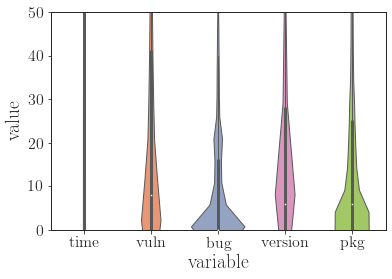

In [150]:
melted_df = pd.melt(all_lags[['image','time','vuln','bug','version','pkg']], id_vars=['image'])
order=['time','vuln','bug','version','pkg']

ax = sns.violinplot(x="variable", 
                 y="value", 
                 data=melted_df,
                 palette='Set2', 
                 linewidth=1,
                 showfliers= False)

ax.set_ylim(0,50)


# PCA

In [156]:
from sklearn.preprocessing import QuantileTransformer
features = ['time','vuln','bug','version','pkg']
# Separating out the features
x = all_lags.loc[:, features].values
# Standardizing the features
#x = QuantileTransformer(output_distribution='normal').fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)

In [157]:
pca.explained_variance_ratio_

array([9.72735803e-01, 2.27223350e-02, 3.16441063e-03, 1.13271226e-03,
       2.44739007e-04])

In [158]:
pca.components_

array([[ 0.99164605,  0.09621647,  0.0284243 ,  0.0703573 ,  0.04027915],
       [-0.12799195,  0.70039002,  0.164523  ,  0.63206617,  0.25786901],
       [ 0.00762973, -0.69745682,  0.30548275,  0.6255167 ,  0.17001445],
       [ 0.00955018, -0.10445373, -0.93609314,  0.29913499,  0.15246673],
       [ 0.01033196,  0.05328803, -0.05034045,  0.33880574, -0.93793931]])

In [147]:
[features[np.abs(pca.components_[i]).argmax()] for i in range(pca.components_.shape[0])]

['vuln']

In [ ]:
# 